<a href="https://colab.research.google.com/github/E-Eshbaugh/CryptoModel_v1/blob/main/CryptoModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## -- 9/22/2025 --


In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [246]:
# last year BTC prices
btc = yf.download('BTC-USD', period='5y')
print(btc.info())

/tmp/ipython-input-3897428234.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', period='5y')
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-09-25 to 2025-09-25
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   1827 non-null   float64
 1   (High, BTC-USD)    1827 non-null   float64
 2   (Low, BTC-USD)     1827 non-null   float64
 3   (Open, BTC-USD)    1827 non-null   float64
 4   (Volume, BTC-USD)  1827 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.6 KB
None


Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2020-10-01  10619.452148  10933.624023  10472.356445  10795.254883   
2020-10-02  10575.974609  10657.837891  10416.689453  10619.821289   
2020-10-03  10549.329102  10598.940430  10511.129883  10575.100586   
2020-10-04  10669.583008  10686.000000  10534.391602  10550.440430   
2020-10-05  10793.339844  10793.507812  10634.600586  10676.529297   

Price            Volume     7-Day_SMA  
Ticker          BTC-USD                
Date                                   
2020-10-01  40023134100  10739.563756  
2020-10-02  48661453918  10722.886300  
2020-10-03  44660271563  10694.115653  
2020-10-04  71251776995  10679.017578  
2020-10-05  47537578009  10690.972935  


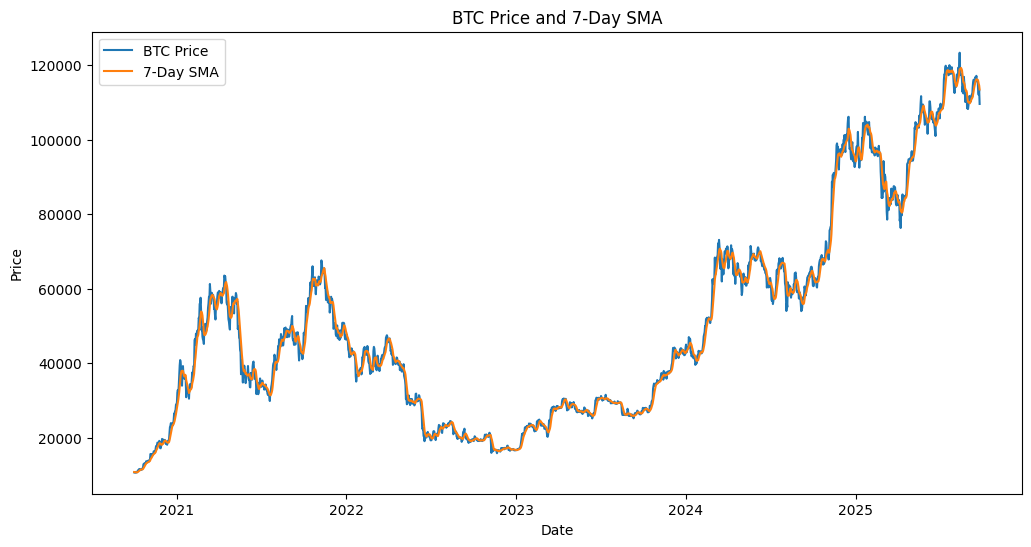

In [247]:
btc['7-Day_SMA'] = btc['Close'].rolling(window=7).mean()
btc = btc.dropna()
print(btc.head())

plot = plt.figure(figsize=(12, 6))
plt.plot(btc['Close'], label='BTC Price')
plt.plot(btc['7-Day_SMA'], label='7-Day SMA')
plt.title('BTC Price and 7-Day SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## -- 9/24/2025 --


In [248]:
# Setting up column for price up (1) or down (0) on the next day.
btc['Next_Day_Movement'] = np.where(btc['Close'].shift(-1) > btc['Close'], 1, 0)
print(btc.head())

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2020-10-01  10619.452148  10933.624023  10472.356445  10795.254883   
2020-10-02  10575.974609  10657.837891  10416.689453  10619.821289   
2020-10-03  10549.329102  10598.940430  10511.129883  10575.100586   
2020-10-04  10669.583008  10686.000000  10534.391602  10550.440430   
2020-10-05  10793.339844  10793.507812  10634.600586  10676.529297   

Price            Volume     7-Day_SMA Next_Day_Movement  
Ticker          BTC-USD                                  
Date                                                     
2020-10-01  40023134100  10739.563756                 0  
2020-10-02  48661453918  10722.886300                 0  
2020-10-03  44660271563  10694.115653                 1  
2020-10-04  71251776995  10679.017578                 1  
2020-10-05  47537578009  10690.97

In [249]:
# Adding RSI calculations

def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

btc['RSI'] = calculate_rsi(btc['Close'])
btc = btc.dropna()
print(btc.head())

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2020-10-14  11429.506836  11539.977539  11307.831055  11429.047852   
2020-10-15  11495.349609  11569.914062  11303.603516  11426.602539   
2020-10-16  11322.123047  11540.061523  11223.012695  11502.828125   
2020-10-17  11358.101562  11386.261719  11285.345703  11322.123047   
2020-10-18  11483.359375  11483.359375  11347.578125  11355.982422   

Price            Volume     7-Day_SMA Next_Day_Movement        RSI  
Ticker          BTC-USD                                             
Date                                                                
2020-10-14  24103426719  11295.922294                 1  75.520033  
2020-10-15  24487233058  11378.731445                 0  76.495162  
2020-10-16  25635480772  11415.540737                 1  70.927629  
2020-10-17  19130430174  

In [250]:
# Adding MACD measurements as well
# Going to keep the EMA calculations for 26, 12, and 9 period as well

btc['EMA_26'] = btc['Close'].ewm(span=26, adjust=False).mean()
btc['EMA_12'] = btc['Close'].ewm(span=12, adjust=False).mean()

btc['MACD'] = btc['EMA_12'] - btc['EMA_26']
btc['Signal_Line'] = btc['MACD'].ewm(span=9, adjust=False).mean()
btc = btc.dropna()
print(btc.head())

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2020-10-14  11429.506836  11539.977539  11307.831055  11429.047852   
2020-10-15  11495.349609  11569.914062  11303.603516  11426.602539   
2020-10-16  11322.123047  11540.061523  11223.012695  11502.828125   
2020-10-17  11358.101562  11386.261719  11285.345703  11322.123047   
2020-10-18  11483.359375  11483.359375  11347.578125  11355.982422   

Price            Volume     7-Day_SMA Next_Day_Movement        RSI  \
Ticker          BTC-USD                                              
Date                                                                 
2020-10-14  24103426719  11295.922294                 1  75.520033   
2020-10-15  24487233058  11378.731445                 0  76.495162   
2020-10-16  25635480772  11415.540737                 1  70.927629   
2020-10-17  1913043

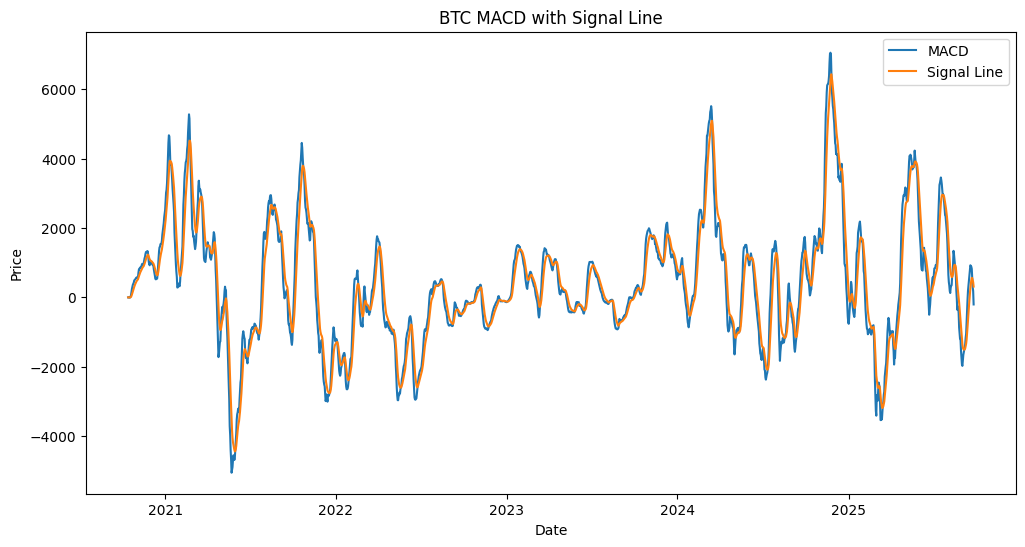

In [251]:
# Plot MACD (with signal line)

plot = plt.figure(figsize=(12, 6))
plt.plot(btc['MACD'], label='MACD')
plt.plot(btc['Signal_Line'], label='Signal Line')
plt.title('BTC MACD with Signal Line')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

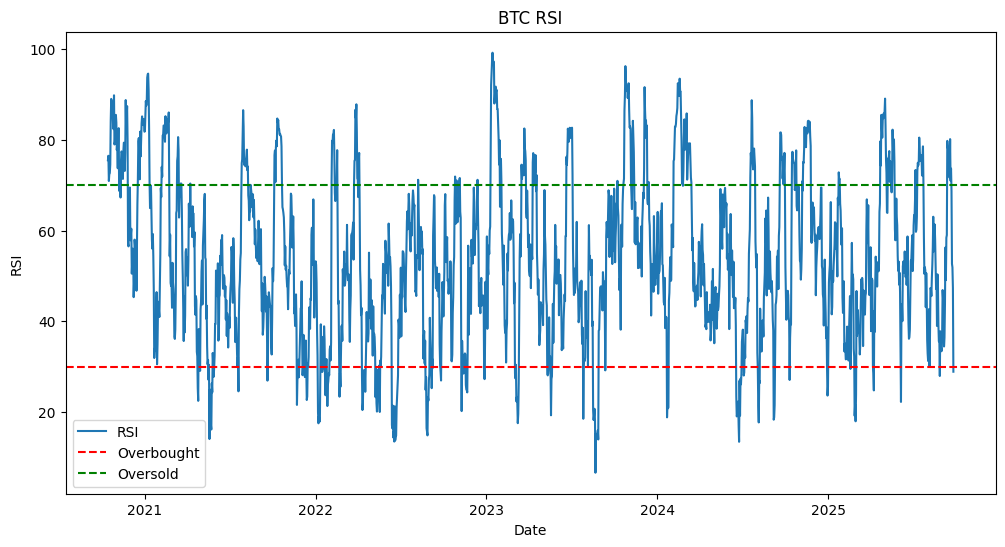

In [252]:
# Plot RSI

plot = plt.figure(figsize=(12, 6))
plt.plot(btc['RSI'], label='RSI')
plt.axhline(y=30, color='r', linestyle='--', label='Overbought')
plt.axhline(y=70, color='g', linestyle='--', label='Oversold')
plt.title('BTC RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

## -- 9/25/2025 --

In [253]:
# First RF Classifer off of data currently using time series slicing. Predicting poor performance - no regime classification, mostly short term trend behavior metrics
X = btc[['7-Day_SMA', 'RSI', 'MACD', 'Signal_Line']].shift(1)
y = btc['Next_Day_Movement']

model = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

accuracies = []
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)

print("Fold accuracies:", accuracies)
print("Mean accuracy:", np.mean(accuracies))

baseline_acc = (y == 1).mean()
print("Baseline accuracy:", baseline_acc)


Fold accuracies: [0.5448504983388704, 0.45182724252491696, 0.5083056478405316, 0.5149501661129569, 0.4019933554817276]
Mean accuracy: 0.48438538205980075
Baseline accuracy: 0.5060840707964602


Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2021-03-12  57332.089844  57996.621094  55376.648438  57821.218750   
2021-03-13  61243.085938  61683.863281  56217.972656  57343.371094   
2021-03-14  59302.316406  61597.917969  59302.316406  61221.132812   
2021-03-15  55907.199219  60540.992188  55393.164062  59267.429688   
2021-03-16  56804.902344  56833.179688  53555.027344  55840.785156   

Price            Volume     7-Day_SMA Next_Day_Movement        RSI  \
Ticker          BTC-USD                                              
Date                                                                 
2021-03-12  55689944702  54047.925223                 1  76.384701   
2021-03-13  60669829814  55809.454241                 0  80.610591   
2021-03-14  43901225564  56965.972098                 0  77.794714   
2021-03-15  6641936

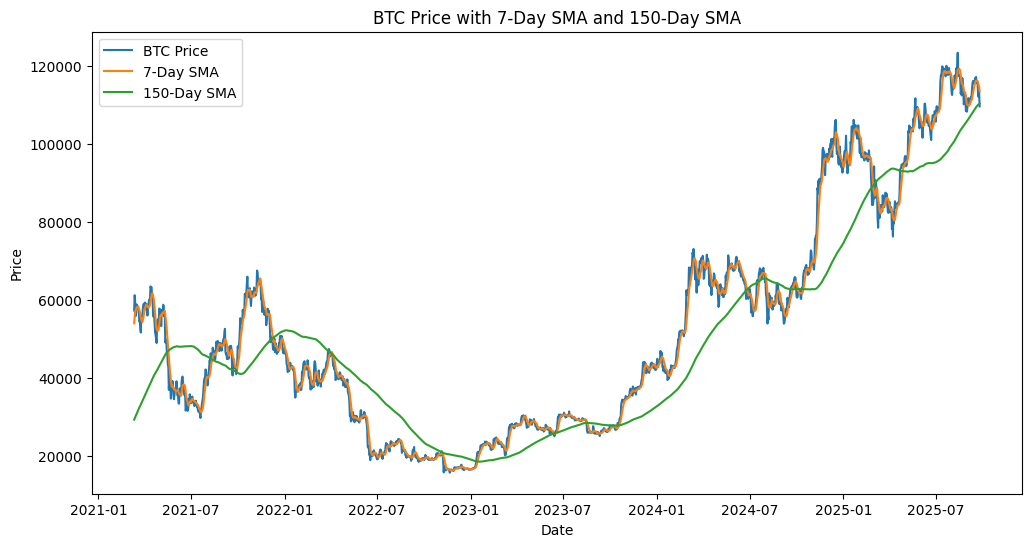

In [254]:
# add a 100-day SMA for more long term
btc['150-Day_SMA'] = btc['Close'].rolling(window=150).mean()
btc = btc.dropna()
print(btc.head())

plot = plt.figure(figsize=(12, 6))
plt.plot(btc['Close'], label='BTC Price')
plt.plot(btc['7-Day_SMA'], label='7-Day SMA')
plt.plot(btc['150-Day_SMA'], label='150-Day SMA')
plt.title('BTC Price with 7-Day SMA and 150-Day SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2021-06-20  35698.296875  36059.484375  33432.074219  35563.140625   
2021-06-21  31676.693359  35721.640625  31295.935547  35641.144531   
2021-06-22  32505.660156  33292.453125  28893.621094  31622.376953   
2021-06-23  33723.027344  34753.410156  31772.632812  32515.714844   
2021-06-24  34662.437500  35228.851562  32385.214844  33682.800781   

Price            Volume     7-Day_SMA Next_Day_Movement        RSI  \
Ticker          BTC-USD                                              
Date                                                                 
2021-06-20  36664034054  37732.389509                 0  49.569226   
2021-06-21  52809038594  36512.134766                 1  45.463477   
2021-06-22  58964353058  35383.476283                 1  47.751837   
2021-06-23  4631710

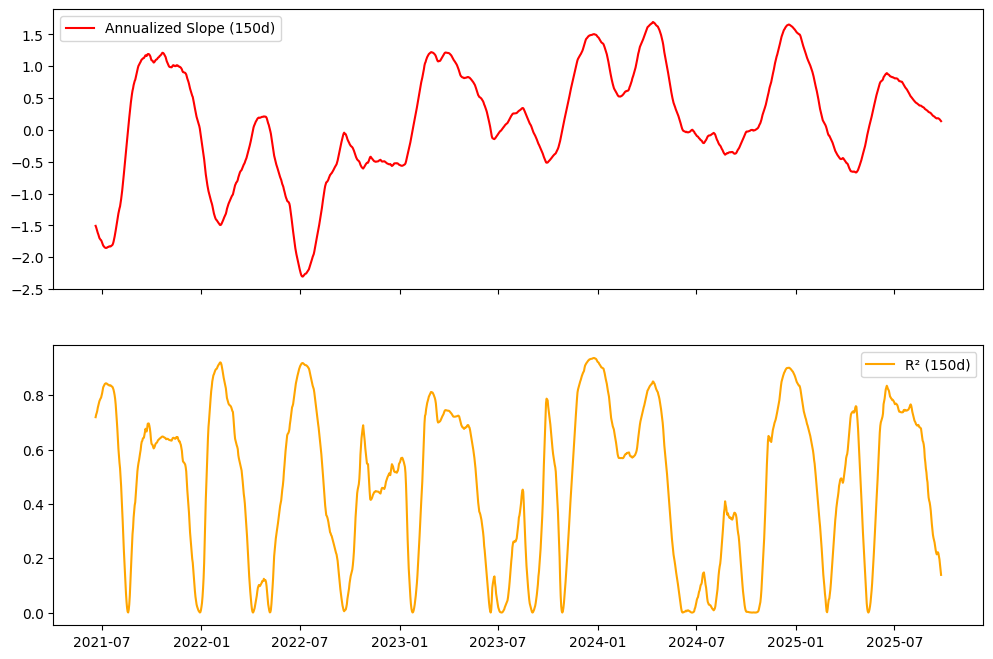

In [255]:
# Adding a 150-day slope with R^2 value to look at regime behavior changes

def rolling_trend_features(df, window=150):
    y = np.log(df[('Close', 'BTC-USD')])
    x = np.arange(len(y), dtype=float)

    slopes = pd.Series(index=df.index, dtype=float)
    r2s = pd.Series(index=df.index, dtype=float)

    for i in range(window, len(df)):
        yi = y.iloc[i-window:i]
        xi = x[i-window:i]

        A = np.vstack([xi, np.ones(len(xi))]).T
        coefficients = np.linalg.lstsq(A, yi, rcond=None)[0]
        beta = float(coefficients[0])
        alpha = float(coefficients[1])

        yhat = alpha + beta * xi
        ss_res = ((yi.to_numpy() - yhat)**2).sum()
        ss_tot = ((yi - yi.mean())**2).sum()
        r2 = 1 - ss_res/ss_tot if float(ss_tot) > 0 else np.nan

        slopes.iloc[i] = beta
        r2s.iloc[i] = r2

    return slopes.rename(f"slope_{window}"), r2s.rename(f"r2_{window}")

btc["slope_150"], btc["r2_150"] = rolling_trend_features(btc, 100)
btc["slope_150_annualized"] = btc["slope_150"] * 252
btc = btc.dropna()
print(btc.head())

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
ax[0].plot(btc.index, btc["slope_150_annualized"], label="Annualized Slope (150d)", color="red")
ax[0].legend()
ax[1].plot(btc.index, btc["r2_150"], label="R² (150d)", color="orange")
ax[1].legend()
plt.show()


Regime
TREND_UP      631
TREND_DOWN    435
CHOP          384
NEUTRAL       109
Name: count, dtype: int64


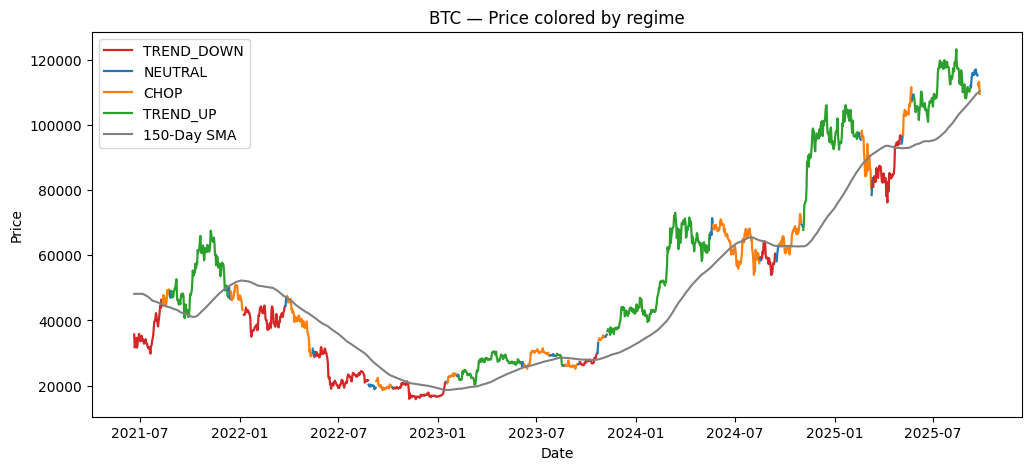

In [256]:
# Label regimes SLOPE_DOWN, SLOPE_UP, CHOP
def label_regime(r2, slope_ann, r2_hi=0.30, r2_lo=0.20, s_hi=0.25, s_lo=0.10):
    r2_scalar = r2.item() if isinstance(r2, pd.Series) else r2
    slope_ann_scalar = slope_ann.item() if isinstance(slope_ann, pd.Series) else slope_ann

    if (r2_scalar >= r2_hi) and (abs(slope_ann_scalar) >= s_hi):
        return "TREND_UP" if slope_ann_scalar > 0 else "TREND_DOWN"
    if (r2_scalar <= r2_lo) or (abs(slope_ann_scalar) < s_lo):
        return "CHOP"
    return "NEUTRAL"

btc['Regime'] = btc.apply(lambda x: label_regime(x["r2_150"], x["slope_150_annualized"]), axis=1)
print(btc['Regime'].value_counts())

def plot_regime_price(df, price_col="Close", regime_col="regime", colors=None, title="BTC — Price colored by regime", linewidth=1.6):
    if colors is None:
        colors = {
            "TREND_UP": "tab:green",
            "TREND_DOWN": "tab:red",
            "CHOP": "tab:orange",
            "NEUTRAL": "tab:blue"
        }

    price = df[price_col].copy()
    regime = df[regime_col].copy()
    sr = pd.DataFrame({"price": price, "Regime": regime}).dropna().sort_index()
    seg_id = (sr["Regime"] != sr["Regime"].shift(1)).cumsum()

    fig, ax = plt.subplots(figsize=(12, 5))

    seen = set()
    for _, seg in sr.groupby(seg_id):
        r = seg["Regime"].iloc[0]
        label = r if r not in seen else None
        ax.plot(seg.index, seg["price"],
                color=colors.get(r, "k"),
                linewidth=linewidth,
                label=label)
        seen.add(r)
    ax.plot(df['150-Day_SMA'], color='gray', label='150-Day SMA')
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    if seen:
        ax.legend()
    plt.show()


plot_regime_price(btc, price_col=("Close","BTC-USD"), regime_col="Regime")